# Results plots
## Model Selection

In [1]:
import numpy as np
import pandas as pd

# Define paths
root_directory = "C:/.../fiftyshadesofgrey"
path_res = root_directory + "/data/out/"

# Load df_res
df_res = pd.read_csv(path_res+'all_greybox_model_fits.csv')
df_paths = pd.read_csv(path_res+'all_greybox_model_paths.csv')
# Drop first column & set index as uuid
df_res = df_res.drop(['Unnamed: 0'], axis=1).set_index("uuid")
df_paths = df_paths.drop(['Unnamed: 0'], axis=1).set_index("uuid")
df_paths = df_paths.fillna(0)

# Groupby Object to identify model duplicates in model selection path
df_paths_groupby = df_paths.groupby(df_paths.columns.values.tolist())
df_paths_group = df_paths_groupby.size().reset_index()

columns_considered = ['ite1', 'ite2', 'ite3', 'ite4', 'ite5', 'ite6']

# Formating counts for Sankey ploting
df_sankey = pd.DataFrame(df_paths_group).reset_index().rename(columns = {0:'count'})
# Sorting the frame
df_sankey.sort_values(by=['count'], ascending=False, inplace=True)
df_sankey.reset_index(inplace=True, drop=True)
df_sankey.replace(0, np.nan, inplace=True)

df_sankey.head()

,index,ite1,ite2,ite3,ite4,ite5,ite6,count
0,NaN,Ti,TiTe,TiTeTh,NaN,NaN,NaN,1
1,1.0,Ti,TiTe,TiTeTs,TiTmTeTs,NaN,NaN,1
2,2.0,Ti,TiTh,TiTmTh,NaN,NaN,NaN,1


In [2]:
import seaborn as sns
import plotly.io as pio
from plotly.offline import plot
import plotly.graph_objects as go

def genSankey(df, cat_cols=[], value_cols='', title='Sankey Diagram'):
    """Wrapper function for Sankey Diagram.
    Source: https://medium.com/kenlok/how-to-create-sankey-diagrams-from-dataframes-in-python-e221c1b4d6b0"""

    # maximum of 6 value cols -> 6 colors
    colorPalette = sns.color_palette("Spectral", len(cat_cols)).as_hex()
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp = list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp

    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))

    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]] * colorNum

    # transform df into a source-target pair
    for i in range(len(cat_cols) - 1):
        if i == 0:
            sourceTargetDf = df[[cat_cols[i], cat_cols[i + 1], value_cols]]
            sourceTargetDf.columns = ['source', 'target', 'count']
        else:
            tempDf = df[[cat_cols[i], cat_cols[i + 1], value_cols]]
            tempDf.columns = ['source', 'target', 'count']
            sourceTargetDf = pd.concat([sourceTargetDf, tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source', 'target']).agg({'count': 'sum'}).reset_index()

    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))

    # creating the sankey diagram
    data = dict(
        type='sankey',
        node=dict(
            pad=15,
            thickness=20,
            line=dict(
                color="black",
                width=0.5
            ),
            label=labelList,
            color=colorList
        ),
        link=dict(
            source=sourceTargetDf['sourceID'],
            target=sourceTargetDf['targetID'],
            value=sourceTargetDf['count']
        )
    )

    layout = dict(
        title=title,
        font=dict(
            family="Times New Roman",
            size=16
        )
    )

    fig_dict = dict(data=[data], layout=layout)
    return fig_dict

In [3]:
### PLOTTING
fig_dict = genSankey(df_sankey, cat_cols=columns_considered, value_cols='count', title='')
# Inline plot
fig = go.Figure(fig_dict)
fig.show()

# Grey-box model type proportions

C:\Users\20190285\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:164: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\20190285\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:199: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\20190285\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:336: UserWarning:

FixedFormatter should only be used together with FixedLocator



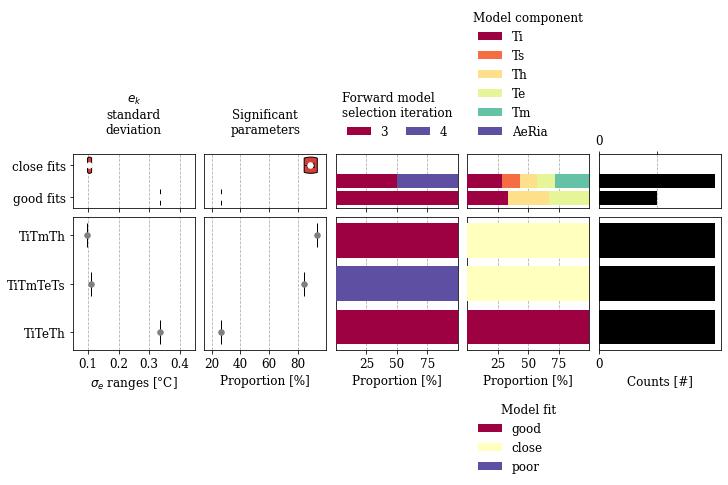

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import itertools
import math
from scipy.stats import gaussian_kde

def rof(x):   
  '''round up to multiple of 5'''
  if x%5==4:
      x+=1
  elif x%5==3:
      x+=2
  return x

### DATA PREP
# Groupby keys
df_res["nCPBES_groups"] = pd.cut(df_res["nCPBES"], bins=[-0.01, 0.01, 0.025, 0.9], labels=['good', 'close', 'poor'])
index = df_res.groupby(['nCPBES_groups']).size().index

df_res1 = df_res.copy()

# Font
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Subplots
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
spec = gridspec.GridSpec(ncols=5, nrows=2, figure=fig,
                         height_ratios=[2, 5], 
                         left=0, right=1, hspace=0,
                        )

axs11 = fig.add_subplot(spec[0,0])
axs21 = fig.add_subplot(spec[0,1], sharey=axs11)
axs31 = fig.add_subplot(spec[0,2])
axs41 = fig.add_subplot(spec[0,3], sharey=axs31)
axs81 = fig.add_subplot(spec[0,4], sharey=axs31)

axs12 = fig.add_subplot(spec[1,0])
axs22 = fig.add_subplot(spec[1,1], sharey=axs12)
axs32 = fig.add_subplot(spec[1,2])
axs42 = fig.add_subplot(spec[1,3], sharey=axs32)
axs82 = fig.add_subplot(spec[1,4], sharey=axs32)



### RESIDUAL PLOT
sign_groups = []
for key in index:
  idx = list(df_res.groupby(['nCPBES_groups']).groups[key])
  if len(idx) > 0:
    # Significance
    sign_groups.append(df_res.loc[idx, 'residual_std'].values)

# Source: https://matplotlib.org/stable/gallery/statistics/customized_violin.html#sphx-glr-gallery-statistics-customized-violin-py
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
# VIOLIN PLOT
parts = axs11.violinplot(sign_groups, showmeans=False, showmedians=False, showextrema=False, vert=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
quartile1, medians, quartile3 = [], [], []
for l in sign_groups:
    quartile1.append(np.percentile(l, [25, 50, 75])[0])
    medians.append(np.percentile(l, [25, 50, 75])[1])
    quartile3.append(np.percentile(l, [25, 50, 75])[2])
whiskers = np.array([adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(sign_groups, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
inds = np.arange(1, len(medians) + 1)
axs11.scatter(medians, inds, marker='o', color='white', s=30, zorder=3)
axs11.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
axs11.hlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
 # Ticks
axs11.set_xlim(0.05, 0.45)
axs11.set_xticks([0.1, 0.2, 0.3, 0.4])
axs11.set_axisbelow(True)
axs11.xaxis.set_ticklabels([])
axs11.grid(axis='x', linestyle='--', zorder=-1)
axs11.set_title('$e_k$\nstandard\ndeviation\n', fontsize=12)

axs21.set_yticks([1, 2, 3])
axs21.set_yticklabels(['good fits', 'close fits', 'poor fits'], fontsize=12)

### SIGNIFICANCE PLOT
sign_groups = []
for key in index:
  idx = list(df_res.groupby(['nCPBES_groups']).groups[key])
  if len(idx) > 0:
    # Significance
    sign_groups.append(df_res.loc[idx, 'significance_prop'].values)

# Source: https://matplotlib.org/stable/gallery/statistics/customized_violin.html#sphx-glr-gallery-statistics-customized-violin-py
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
# VIOLIN PLOT
parts = axs21.violinplot(sign_groups, showmeans=False, showmedians=False, showextrema=False, vert=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
quartile1, medians, quartile3 = [], [], []
for l in sign_groups:
    quartile1.append(np.percentile(l, [25, 50, 75])[0])
    medians.append(np.percentile(l, [25, 50, 75])[1])
    quartile3.append(np.percentile(l, [25, 50, 75])[2])
whiskers = np.array([adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(sign_groups, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
inds = np.arange(1, len(medians) + 1)
axs21.scatter(medians, inds, marker='o', color='white', s=30, zorder=3)
axs21.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
axs21.hlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
 # Ticks
#axs21.set_xlabel('Proportion [%]', fontsize=12)
axs21.set_axisbelow(True)
axs21.grid(axis='x', linestyle='--', zorder=-1)
axs21.set_xticks([20, 40, 60, 80])
axs21.set_xlim(15,100)
axs21.xaxis.set_ticklabels([])
axs21.set_title('Significant\nparameters\n', fontsize=12)

axs21.yaxis.set_visible(False)


### Proportion of model iteration
parameter = 'iteration'   # home_type, home_size
df_res1[parameter].fillna("Unknown", inplace=True)
# defining color map - https://towardsdatascience.com/stacked-bar-charts-with-pythons-matplotlib-f4020e4eb4a7
cmap = matplotlib.cm.get_cmap('Spectral')
colors = []
int = 0
for i in np.linspace(0,1,len(df_res1[parameter].unique())):
    colors.append(cmap(i))
counts = df_res1.groupby(['nCPBES_groups', parameter]).size().reset_index().pivot_table(values=0, index=['nCPBES_groups'], columns=parameter, aggfunc=np.sum).fillna(0)
counts = counts.loc[index]
counts.index = pd.Index(index, name='nCPBES_groups')
counts = counts.loc[:, counts.columns != 'Unknown'].divide( counts.loc[:, counts.columns != 'Unknown'].sum(axis=1), axis='index').fillna(0)*100

left = len(counts) * [0]
for idx, name in enumerate(counts.columns):
    axs31.barh(counts.index, counts[name], left = left, color=colors[idx], label=name, zorder=3)
    left = left + counts[name]
# Legend
axs31.legend(prop={'size': 12}, title = "Forward model\nselection iteration", title_fontsize='large', frameon=False, 
             bbox_to_anchor=(0, 1.1, 1, 0), loc="lower left", mode="expand", ncol=2)
#axs31.set_xlabel('Proportion [%]', fontsize=12)
axs31.grid(axis='x', linestyle='--', zorder=0)
# Ticks
axs31.set_yticklabels(counts.index, fontsize=12)
axs31.set_xticks([25, 50, 75])
axs31.set_xlim(0,100)
axs31.xaxis.set_ticklabels([])
axs31.yaxis.set_visible(False)


### Proportion of model components
model_components = ['Ti', 'Ts', 'Th', 'Te', 'Tm', 'AeRia']

# defining color map - https://towardsdatascience.com/stacked-bar-charts-with-pythons-matplotlib-f4020e4eb4a7
cmap = matplotlib.cm.get_cmap('Spectral')
colors = []
int = 0
for i in np.linspace(0,1,len(model_components)):
    colors.append(cmap(i))

counts = pd.DataFrame(df_res1.groupby(['nCPBES_groups', 'model_name']).size().to_frame('size'))
for idx in counts.index:
  for col in model_components:
    counts.loc[idx,col] = counts.loc[idx, 'size'] if col in idx[1] else 0
counts = counts.groupby(level=0, axis=0).sum().loc[:,model_components]
counts.index = pd.Index(index, name='nCPBES_groups')
counts = counts.loc[:, counts.columns != 'Unknown'].divide( counts.loc[:, counts.columns != 'Unknown'].sum(axis=1), axis='index').fillna(0)*100

left = len(counts) * [0]
for idx, name in enumerate(counts.columns):
    axs41.barh(counts.index, counts[name], left = left, color=colors[idx], label=name, zorder=3)
    left = left + counts[name]
# Legend
axs41.legend(prop={'size': 12}, title = "Model component", title_fontsize='large', frameon=False, 
             bbox_to_anchor=(0, 1.1, 1, 0), loc="lower left", mode="expand", ncol=1)
#axs41.set_xlabel('Proportion [%]', fontsize=12)
axs41.grid(axis='x', linestyle='--', zorder=0)
# Ticks
axs41.set_yticklabels(counts.index, fontsize=12)
axs41.set_xticks([25, 50, 75])
axs41.set_xlim(0,100)
axs41.xaxis.set_ticklabels([])
axs41.yaxis.set_visible(False)


## Count plot
counts = df_res1.groupby(['nCPBES_groups']).size().reset_index()

left = len(counts) * [0]
axs81.barh(index, counts[0], left = left, color='k', label='Known', zorder=3)

# Legend
axs81.grid(axis='x', linestyle='--', zorder=0)
# Ticks
tick_list =np.arange(0, rof(round(max(df_res1.groupby(['nCPBES_groups']).size()))), 1)
axs81.set_xticks(tick_list)
nan_list = ([0, np.nan]*math.floor(len(tick_list)/2))
tick_label = [sum(x) for x in itertools.zip_longest(*[tick_list, nan_list], fillvalue=0)]
tick_label = [None if np.isnan(x) else x for x in tick_label]
axs81.set_xticklabels(tick_label, fontsize=12)
axs81.yaxis.set_visible(False)
axs81.xaxis.tick_top()


###########################################################################

### DATA PREP
# Groupby keys
index = df_res.groupby(['model_name']).size().sort_values(ascending=True).index

### RESIDUAL RANGE PLOT
sign_groups = []
for key in index:
  idx = list(df_res.groupby(['model_name']).groups[key])
  # Significance
  sign_groups.append(df_res.loc[idx, 'residual_std'].values)
# Source: https://matplotlib.org/stable/gallery/statistics/customized_violin.html#sphx-glr-gallery-statistics-customized-violin-py
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
# VIOLIN PLOT
parts = axs12.violinplot(sign_groups, showmeans=False, showmedians=False, showextrema=False, vert=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
quartile1, medians, quartile3 = [], [], []
for l in sign_groups:
    quartile1.append(np.percentile(l, [25, 50, 75])[0])
    medians.append(np.percentile(l, [25, 50, 75])[1])
    quartile3.append(np.percentile(l, [25, 50, 75])[2])
whiskers = np.array([adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(sign_groups, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
inds = np.arange(1, len(medians) + 1)
axs12.scatter(medians, inds, marker='o', color='grey', s=30, zorder=3)
axs12.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
axs12.hlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
# Tick
axs12.set_yticks([1, 2, 3])
axs12.set_xlim(0.05, 0.45)
axs12.set_xticks([0.1, 0.2, 0.3, 0.4])
axs12.set_yticklabels(index, fontsize=12)
axs12.set_xlabel('$\sigma_e$ ranges [°C]', fontsize=12)
axs12.set_axisbelow(True)
axs12.grid(axis='x', linestyle='--', zorder=-1)
#axs12.set_title('$e_k$\nStandard\nDeviation\n', fontsize=13)



# Significance
### SIGNIFICANCE PLOT
sign_groups = []
for key in index:
  idx = list(df_res.groupby(['model_name']).groups[key])
  # Significance
  sign_groups.append(df_res.loc[idx, 'significance_prop'].values)
# Source: https://matplotlib.org/stable/gallery/statistics/customized_violin.html#sphx-glr-gallery-statistics-customized-violin-py
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
# VIOLIN PLOT
parts = axs22.violinplot(sign_groups, showmeans=False, showmedians=False, showextrema=False, vert=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
quartile1, medians, quartile3 = [], [], []
for l in sign_groups:
    quartile1.append(np.percentile(l, [25, 50, 75])[0])
    medians.append(np.percentile(l, [25, 50, 75])[1])
    quartile3.append(np.percentile(l, [25, 50, 75])[2])
whiskers = np.array([adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(sign_groups, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
inds = np.arange(1, len(medians) + 1)
axs22.scatter(medians, inds, marker='o', color='grey', s=30, zorder=3)
axs22.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
axs22.hlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
# Ticks
axs22.yaxis.set_visible(False)
axs22.set_xlabel('Proportion [%]', fontsize=12)
axs22.set_axisbelow(True)
axs22.grid(axis='x', linestyle='--', zorder=-1)
axs22.set_xticks([20, 40, 60, 80])
axs22.set_xlim(15,100)
#axs22.set_title('Significant\nparameters\n', fontsize=13)

### Proportion of model iteration
parameter = 'iteration'   # home_type, home_size
df_res1[parameter].fillna("Unknown", inplace=True)
# defining color map - https://towardsdatascience.com/stacked-bar-charts-with-pythons-matplotlib-f4020e4eb4a7
cmap = matplotlib.cm.get_cmap('Spectral')
colors = []
int = 0
for i in np.linspace(0,1,len(df_res1[parameter].unique())):
    colors.append(cmap(i))
counts = df_res1.groupby(['model_name', parameter]).size().reset_index().pivot_table(values=0, index=['model_name'], columns=parameter, aggfunc=np.sum).fillna(0)
counts = counts.loc[index]
counts = counts.loc[:, counts.columns != 'Unknown'].divide( counts.loc[:, counts.columns != 'Unknown'].sum(axis=1), axis='index').fillna(0)*100

left = len(counts) * [0]
for idx, name in enumerate(counts.columns):
    axs32.barh(counts.index, counts[name], left = left, color=colors[idx], label=name, zorder=3)
    left = left + counts[name]
# Legend
axs32.set_xlabel('Proportion [%]', fontsize=12)
axs32.grid(axis='x', linestyle='--', zorder=0)
# Ticks
axs32.set_yticklabels(counts.index, fontsize=12)
axs32.set_xticks([25, 50, 75])
axs32.set_xlim(0,100)
axs32.yaxis.set_visible(False)

# Model fits
# Groupby keys
df_res["nCPBES_groups"] = pd.cut(df_res["nCPBES"], bins=[-0.01, 0.01, 0.025, 0.9], labels=['good', 'close', 'poor'])

parameter = "nCPBES_groups"
# defining color map - https://towardsdatascience.com/stacked-bar-charts-with-pythons-matplotlib-f4020e4eb4a7
cmap = matplotlib.cm.get_cmap('Spectral')
colors = []
for i in np.linspace(0,1,len(df_res[parameter])):
    colors.append(cmap(i))
counts = df_res.groupby(['model_name', parameter]).size().reset_index().pivot_table(values=0, index=['model_name'], columns=parameter, aggfunc=np.sum).fillna(0)
counts = counts.loc[index]
counts = counts.loc[:, counts.columns != 'Unknown'].divide( counts.loc[:, counts.columns != 'Unknown'].sum(axis=1), axis='index').fillna(0)*100

left = len(counts) * [0]
for idx, name in enumerate(counts.columns):
    axs42.barh(index, counts[name], left = left, color=colors[idx], label=name, zorder=3)
    left = left + counts[name]
# Legend
axs42.legend(prop={'size': 12}, title = "Model fit", title_fontsize='large', frameon=False, 
            bbox_to_anchor=(0, -1, 1, 0), loc="lower left", mode="expand", ncol=1)  # "Home size [$m^2$]"
axs42.set_xlabel('Proportion [%]', fontsize=12)
axs42.grid(axis='x', linestyle='--', zorder=0)
# Ticks
axs42.set_xticks([25, 50, 75])
axs42.set_xlim(0,100)
axs42.yaxis.set_visible(False)

## Count plot
counts = df_res.groupby(['model_name']).size().reset_index().fillna(0)

left = len(counts) * [0]
axs82.barh(index, counts[0], left = left, color='k', label='Known', zorder=3)


# Legend
axs82.set_xlabel('Counts [#]', fontsize=12)
axs82.grid(axis='x', linestyle='--', zorder=0)
# Ticks
tick_list =np.arange(0, rof(round(max(df_res.groupby(['model_name']).size()))), 1)
axs82.set_xticks(tick_list)
nan_list = ([0, np.nan]*math.floor(len(tick_list)/2))
tick_label = [sum(x) for x in itertools.zip_longest(*[tick_list, nan_list], fillvalue=0)]
tick_label = [None if np.isnan(x) else x for x in tick_label]
axs82.set_xticklabels(tick_label, fontsize=12)
axs82.yaxis.set_visible(False)


# Saving figure
path_fig = root_directory + "/fig/"
plt.savefig(path_fig+"GB_model_distribution.jpeg", format='jpeg', dpi=150, bbox_inches='tight')

# Estimated RC parameter scatter

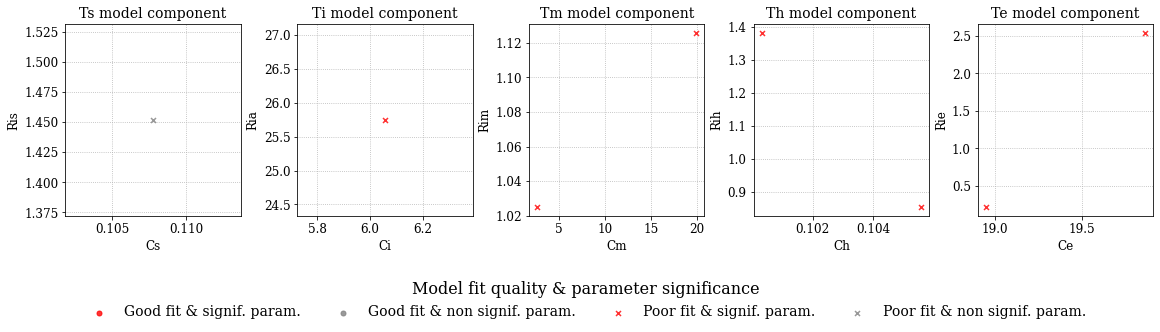

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import itertools
import math

# Load df_res
df_res = pd.read_csv(path_res+'all_final_fits.csv')
# Drop first column & set index as uuid
df_res = df_res.drop(['Unnamed: 0'], axis=1).set_index("uuid")

### DATA PREP
dic_params = {"Ts": ['Cs', 'Ris'], "Ti": ['Ci', 'Ria'], "Tm": ['Cm', 'Rim'], "Th": ['Ch', 'Rih'], "Te": ['Ce', 'Rie']}
             #"TeAeRia": ['Ae', 'Rie']}
dic_paramsp = {"Ts": ['Cs_p', 'Ris_p'], "Ti": ['Ci_p', 'Ria_p'], "Tm": ['Cm_p', 'Rim_p'], "Th": ['Ch_p', 'Rih_p'], "Te": ['Ce_p', 'Rie_p']}
  
# Font
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Subplots
col_nb = len(dic_params.keys())
fig = plt.figure(constrained_layout=True, figsize=(16, 3.5))
spec = gridspec.GridSpec(ncols=col_nb, nrows=1, figure=fig,
                         #height_ratios=[2, 5], 
                         left=0, right=1, #hspace=-1
                        )

# Plots
axs = dict()
i=0
for key in dic_params:
  # subplot
  axs[i] = fig.add_subplot(spec[i])
  # scatter
  group1 = df_res['nCPBES'].values
  group2 = df_res[dic_paramsp[key][0]].values
  group3 = df_res[dic_paramsp[key][1]].values
  
  ixg = np.where(group1 <= 0.01)[0]
  ixb = np.where(group1 > 0.01)[0]
  
  ixs1 = np.where(group2 <= 0.05)[0]
  ixs2 = np.where(group3 <= 0.05)[0]
  ixns1 = np.where(group2 <= 0.05)[0]
  ixns2 = np.where(group3 <= 0.05)[0]
  
  label_goodfit_sign = 'Good fit & signif. param.' if (key == 'Te') else ''
  label_poorfit_sign = 'Poor fit & signif. param.' if (key == 'Te') else ''
  label_goodfit_nosign = 'Good fit & non signif. param.' if (key == 'Te') else ''
  label_poorfit_nosign = 'Poor fit & non signif. param.' if (key == 'Te') else ''
  
  significance_intersect = [value for value in ixs1 if value in ixs2]
  significance_nonintersect = [value for value in ixs1 if value not in ixs2]
  nonsignificance_intersect = [value for value in ixns1 if value in ixns2]
  
  # Indexes to plot
  goodfit_significant = [value for value in ixg if value in significance_intersect]
  goodfit_nonsignificant1 = [value for value in ixg if value not in significance_intersect]
  goodfit_nonsignificant2 = [value for value in ixg if value in significance_nonintersect]
  poorfit_significant = [value for value in ixb if value in significance_intersect]
  poorfit_nonsignificant1 = [value for value in ixb if value not in significance_intersect]
  poorfit_nonsignificant2 = [value for value in ixb if value in significance_nonintersect]

  ix = df_res.iloc[goodfit_significant].index
  axs[i].scatter(x=df_res.loc[ix,dic_params[key][0]], 
                 y=df_res.loc[ix,dic_params[key][1]],
                 color = "red", 
                 label = label_goodfit_sign,
                 alpha=0.8,
                 s = 25,
                 marker= "o",
                 zorder=3)
  ix = df_res.iloc[goodfit_nonsignificant1].index
  axs[i].scatter(x=df_res.loc[ix,dic_params[key][0]], 
           y=df_res.loc[ix,dic_params[key][1]],
           color = 'red', 
           label = '',
           alpha=0.8,
           s = 25,
           marker= "x",
           zorder=3)
  ix = df_res.iloc[goodfit_nonsignificant2].index
  axs[i].scatter(x=df_res.loc[ix,dic_params[key][0]], 
           y=df_res.loc[ix,dic_params[key][1]],
           color = 'grey', 
           label = label_goodfit_nosign,
           alpha=0.8,
           s = 25,
           marker= "o",
           zorder=3)
  ix = df_res.iloc[poorfit_significant].index
  axs[i].scatter(x=df_res.loc[ix,dic_params[key][0]], 
                 y=df_res.loc[ix,dic_params[key][1]],
                 color = "red", 
                 label = label_poorfit_sign,
                 alpha=0.8,
                 s = 25,
                 marker= "x",
                 zorder=3)
  ix = df_res.iloc[poorfit_nonsignificant1].index
  axs[i].scatter(x=df_res.loc[ix,dic_params[key][0]], 
           y=df_res.loc[ix,dic_params[key][1]],
           color = 'grey', 
           label = '',
           alpha=0.8,
           s = 25,
           marker= "x",
           zorder=3)
  ix = df_res.iloc[poorfit_nonsignificant2].index
  axs[i].scatter(x=df_res.loc[ix,dic_params[key][0]], 
           y=df_res.loc[ix,dic_params[key][1]],
           color = 'grey', 
           label = label_poorfit_nosign,
           alpha=0.8,
           s = 25,
           marker= "x",
           zorder=3)
  
  # params
  axs[i].set_title(key+" model component", fontsize=14)
  # Labels
  axs[i].set_xlabel(dic_params[key][0], fontsize=12)
  axs[i].set_ylabel(dic_params[key][1], fontsize=12)
  
  axs[i].grid(axis='x', linestyle=':', zorder=0)
  axs[i].grid(axis='y', linestyle=':', zorder=0)

  i += 1

# Legend
fig.legend(prop={'size': 14}, ncol=4, title = "Model fit quality & parameter significance", title_fontsize=16, frameon=False,  
                bbox_to_anchor=(.95, -.05))
#display()

## Saving figure
path_fig = root_directory + "/fig/"
plt.savefig(path_fig+"GB_RC_param.jpeg", format='jpeg', dpi=150, bbox_inches='tight')

# Total Capacity and Heat Transfer Coefficient (HTC) scatter

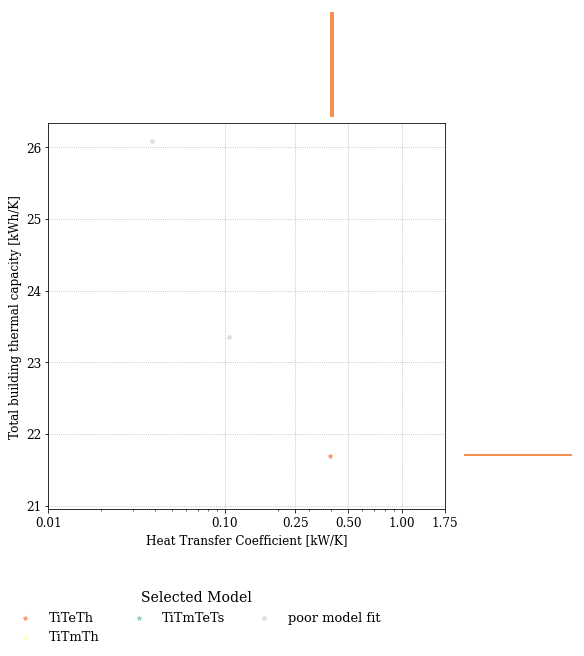

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker
import matplotlib

# Font
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Get Unique models
group_by_param = 'model_name'
model_group = list(df_res[group_by_param].unique())
model_group = sorted(model_group, key=lambda el: len(el))
# Color map
# List of colors in the color palettes
rgb_values = sns.color_palette("Spectral", len(model_group))
# Map continents to the colors
color_map = dict(zip(model_group, rgb_values))
# Color map
cmap = matplotlib.cm.get_cmap('Spectral')
colors = []
int = 0
for i in np.linspace(0,1,len(model_group)):
    colors.append(cmap(i))


# Figure declaration
fig = plt.figure(figsize=(8,9), constrained_layout=True)

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=-0.05, hspace=-0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

## Scatter
# adapted from https://stackoverflow.com/questions/47006268/matplotlib-scatter-plot-with-color-label-and-legend-specified-by-c-option
group = df_res[group_by_param].values
group2 = df_res['nCPBES'].values
for g in model_group:
    ix1 = np.where(group2 <= 0.01)[0]
    ix2 = np.where(group == g)[0]
    ix_intersect = [value for value in ix1 if value in ix2]
    ix = df_res.iloc[ix_intersect].index
    
    ax.scatter(x=df_res.loc[ix,'HTC'], 
               y=df_res.loc[ix,['Ci', 'Cm', 'Ce', 'Ch', 'Cs']].sum(axis=1),
               color = color_map[g], 
               label = g,
               marker= "*",
               alpha = 0.8,
               s = 20, 
               zorder=3)
ix = np.where(group2 > 0.01)[0]
ix = df_res.iloc[ix].index
ax.scatter(x=df_res.loc[ix,'HTC'], 
           y=df_res.loc[ix,['Ci', 'Cm', 'Ce', 'Ch', 'Cs']].sum(axis=1),
           color = 'grey', 
           label = 'poor model fit',
           #marker= "x",
           alpha=0.2,
           s = 15,
           zorder=3)

# Input data separation
df_res["nCPBES_groups"] = pd.cut(df_res["nCPBES"], bins=[-0.01, 0.01, 0.025, 0.9], labels=['good', 'close', 'poor'])
ix_goodfits = np.where(df_res['nCPBES_groups'].values == 'good')[0]
df_res1 = df_res.iloc[ix_goodfits,:]

x, y = pd.DataFrame(), pd.DataFrame()
for i in model_group:
  x = pd.concat([x, df_res1.loc[df_res1[group_by_param] == i, 'HTC'].reset_index()['HTC']], axis=1)
  y = pd.concat([y, df_res1.loc[df_res1[group_by_param] == i, ['Ci', 'Cm', 'Ce', 'Ch', 'Cs']].reset_index()[['Ci', 'Cm', 'Ce', 'Ch', 'Cs']].sum(axis=1)], axis=1)
x.columns = model_group
y.columns = model_group
# Histogram distributions
ax_histx.hist(x.values, bins=50, density=True, 
              histtype='bar', stacked=True, ls='solid', zorder=3, 
              color=list(color_map.values()), alpha = 1, label=[str(x) for x in x.columns])
ax_histy.hist(y.values, bins=40, density=True, orientation='horizontal',
              histtype='bar', stacked=True, ls='solid', zorder=3, 
              color=list(color_map.values()), alpha = 1, label=[str(x) for x in y.columns])

#ax_histy.set_yscale('log')
ax_histx.set_xscale('log')

ax.set_xticks([0.01, 0.1, 0.25, 0.5, 1, 1.75])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False

# Make some axis invisible
ax_histx.axis('off')
ax_histy.axis('off')

# Grid
ax.grid(axis='x', linestyle=':', zorder=0)
ax.grid(axis='y', linestyle=':', zorder=0)
# Labels
ax.set_xlabel('Heat Transfer Coefficient [kW/K]', fontsize=12)
ax.set_ylabel('Total building thermal capacity [kWh/K]', fontsize=12)
# Legend
ax.legend(prop={'size': 13}, ncol=3, title = "Selected Model", title_fontsize=14, frameon=False,
                bbox_to_anchor=(-.12, -0.18), loc="upper left")

# Saving figure
plt.savefig(path_fig+"GB_HTC_scatter.jpeg", format='jpeg', dpi=150, bbox_inches='tight')